In [1]:
%matplotlib notebook

Plot traces and boxplots similar to Figure 1

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from pathlib import Path
from natsort import natsorted
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
import statsmodels.api as sm
from scipy.signal import savgol_filter
import matplotlib.ticker as plticker


# to import package in parent folder first add the parent folder to path
import sys
import os
packages_path = Path(os.path.dirname(os.path.realpath('__file__'))).parent
sys.path.insert(0, str(packages_path))

import shared_func

In [3]:
home_path = os.getcwd()

filepath = Path(home_path, 'Fig4_data')
savepath = Path(home_path, 'plots')
stat_savepath = Path(home_path, 'stats')

Path(savepath).mkdir(parents=True, exist_ok=True) 
Path(stat_savepath).mkdir(parents=True, exist_ok=True) 

# Hyperscope data (larva) comes with 30 Hz image aquisition frequency
aq_rate = 30

# different light intensities

Need to define the color before I can plot the first figure. That's why this plot comes before plotting the ATR+/- comparison

In [4]:
filename = 'Fig4_HI_JK73A'

data = np.load(Path(filepath, filename + '.npy'))
adult=True
# and also read the metadata to have everything in one place
with open(Path(filepath, filename + '.txt')) as f:
    metadata = f.read()
    print(metadata)
# Aquisition rate on the Bergamo II scope
aq_rate = 1/0.140757247 # copy paste from csv file, time for each frame

This numpy array contains the data collected for revision 
which shows response of control animals with UAS-Chrimson in JK73A
at 72uW/mm2, 288uW/mm2 and 1151uW/mm2 with 660nm stimulation light
 shown in Figure 3H and I.

Output data is organized the following way:

1st dimension is 210. These are the datapoints 

2nd dimension is 8. These are: Time, Stim, df/f1, df/f2, df/f3, df/f4, df/f5, df/f6. 
Each df/f is a repeat on the same animal 

3rd dimension is 6, one for each animal 

4th dimension is 3. These are: 72, 288, 1151uW/mm2 

5th dimension is 1.


<IPython.core.display.Javascript object>


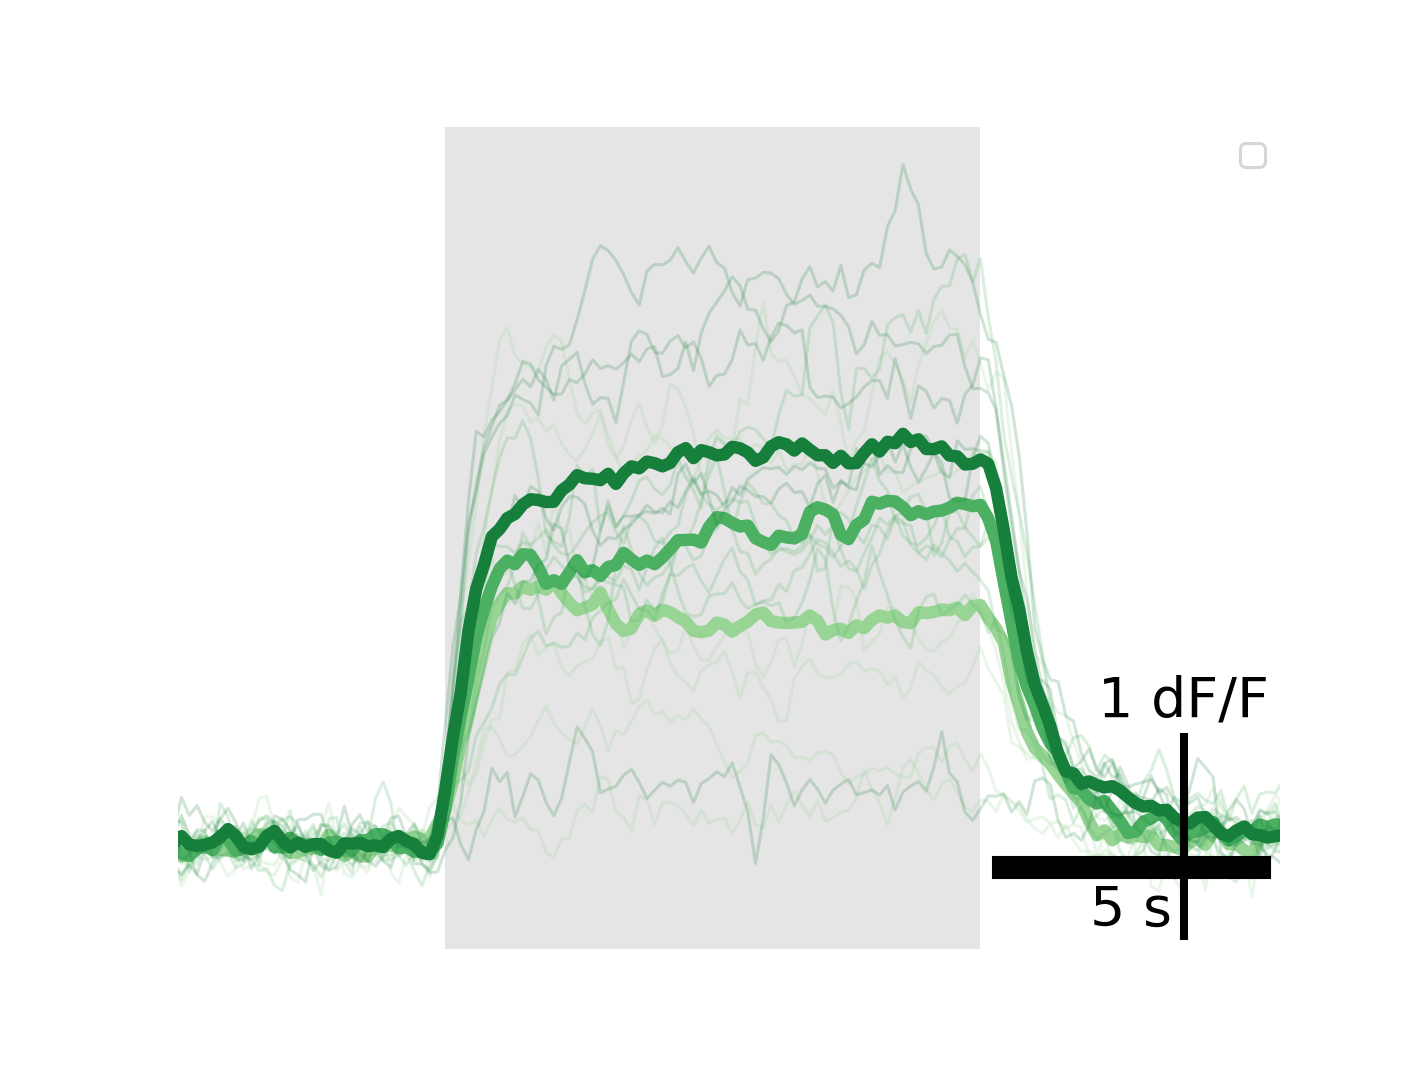

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [5]:
# Define colors used for this plot
start = 0.4
stop = 0.8
number_of_lines= data.shape[3]
cm_subsection = np.linspace(start, stop, number_of_lines) 

colors = [matplotlib.cm.Greens(x) for x in cm_subsection ]
colors = np.array(colors)

# Prepare the raw data for plotting
median_per_animal = shared_func.median_per_animal_func(aq_rate=aq_rate, data=data)

# Then, plot the trace plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Here we have only one group
group = 0

for stim_intensity in range(data.shape[3]):

    ax.plot(data[:,0,0,stim_intensity,group], median_per_animal[:,:,stim_intensity,group], lw=1, zorder=1, 
            color=colors[stim_intensity], alpha=0.2)
    # and plot the mean of the median in bold
    ax.plot(data[:,0,0,stim_intensity,group], np.mean(median_per_animal[:,:,stim_intensity,group], axis=1), 
            lw=4, zorder=1, color=colors[stim_intensity])

# Plot stimulus
start_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][0]
stop_stim = np.where(data[:, 1, 0, stim_intensity, 0] > 0.1)[0][-1]
ax.axvspan(data[start_stim, 0, 0, stim_intensity, 0],
           data[stop_stim, 0, 0, stim_intensity, 0],
           lw=0, zorder=0,
           color='k',
           alpha=0.1)
ax.set_xlim(5,25)

fontprops = fm.FontProperties(size=18)
scalebar_time = AnchoredSizeBar(ax.transData,
                                5, '5 s', 'lower right',
                                pad=0.1,
                                color='black',
                                frameon=False,
                                size_vertical=0.1,
                                fontproperties=fontprops)

scalebar_df = AnchoredSizeBar(ax.transData,
                              0.1, '1 dF/F', 'lower right',
                              pad=0.1,
                              color='black',
                              frameon=False,
                              size_vertical=1,
                              fontproperties=fontprops,
                              label_top=True)

ax.add_artist(scalebar_time)
ax.add_artist(scalebar_df)
ax.legend()
ax.axis('off')

savename = 'Fig4H.svg'
fig.savefig(Path(savepath, savename),
           transparent=True)

In [6]:
# Median values before and during
# For readability explicitly state what is being taken
before_start_index = int(round(start_stim-(aq_rate*1))) # one second before start
before_end_index = int(round(start_stim))

during_start_index = int(round(start_stim)) # From beginning of stimulus...
during_end_index = int(round(stop_stim)) # ...until the end of the stimulus

median_before_stim = np.median(median_per_animal[before_start_index:start_stim, :, :],axis=0)
median_during_stim = np.median(median_per_animal[during_start_index:during_end_index, :, :],axis=0)

<IPython.core.display.Javascript object>


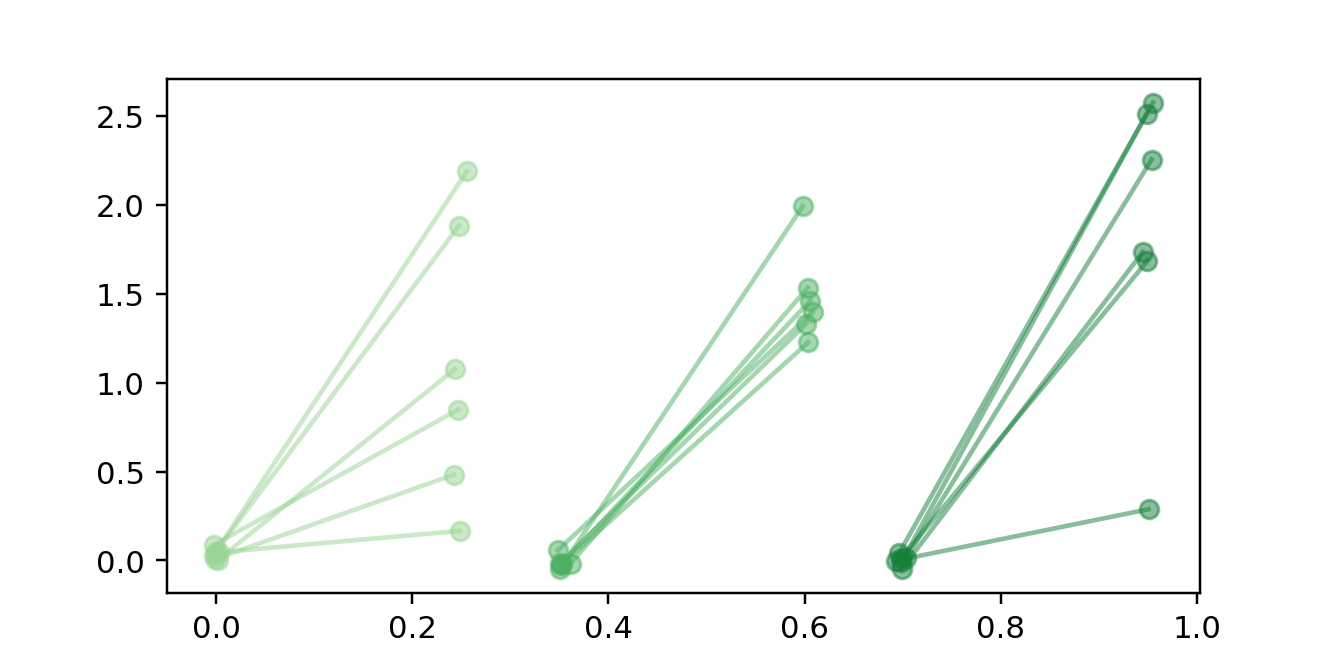

In [7]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=0, 
                           color=colors[0], start_x_position=0)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=1, 
                           color=colors[1], start_x_position=0.35)

shared_func.plot_connected_scatterplot(ax, median_before_stim, median_during_stim, light_intensity=2, 
                           color=colors[2], start_x_position=0.7)
loc = plticker.MultipleLocator(base=0.5)  # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
savename = 'Fig4I.svg'
fig.savefig(Path(savepath, savename),
            transparent=True)

In [8]:
p_values=[]

# median_before_stim.shape
# (6, 3, 1) # Animal, light intensity, group
shared_func.pairwise_t_tests(median_during_stim[:,0,0], median_before_stim[:,0,0], p_values, non_parametric=False) # 72 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,1,0], median_before_stim[:,1,0], p_values, non_parametric=False) # 288 uW/mm2
shared_func.pairwise_t_tests(median_during_stim[:,2,0], median_before_stim[:,2,0], p_values, non_parametric=False) # 1151 uW/mm2

print('Holms-Bonferroni correction:')
shared_func.holms_bonferroni_correction(p_values)

lilliefors: 0.8445138896154578
T-Test
TtestResult(statistic=3.321366042481949, pvalue=0.02097677377518101, df=5)


lilliefors: 0.22931216576024804
T-Test
TtestResult(statistic=12.911276746505713, pvalue=4.9652628067532605e-05, df=5)


lilliefors: 0.28486129697280216
T-Test
TtestResult(statistic=5.352456743022989, pvalue=0.0030580538793885032, df=5)


Holms-Bonferroni correction:
significantly different with:
current p: 4.9652628067532605e-05, current alpha: 0.016666666666666666
significantly different with:
current p: 0.0030580538793885032, current alpha: 0.025
significantly different with:
current p: 0.02097677377518101, current alpha: 0.05


In [9]:
data = [[median_during_stim[:,0,0], median_before_stim[:,0,0]],
        [median_during_stim[:,1,0], median_before_stim[:,1,0]],
        [median_during_stim[:,2,0], median_before_stim[:,2,0]]
       ]

label_list_stat_export = [['During, 72uW/mm2', 'Before, 72uW/mm2'],
                          ['During, 288uW/mm2', 'Before, 288uW/mm2'],
                          ['During, 1151uW/mm2', 'Before, 1151uW/mm2']]
savename = 'Fig_4I'

shared_func.export_pairwise_dependent_test(data, label_list_stat_export,
                                           savepath=stat_savepath, savename=savename,
                                           parametric=True)

                Group  n      mean    median       STD       SEM  \
0    During, 72uW/mm2  6  1.107749  0.962315  0.720977  0.294338   
1    Before, 72uW/mm2  6  0.037779  0.039191  0.028148  0.011491   
2   During, 288uW/mm2  6  1.491066  1.429698  0.244245  0.099713   
3   Before, 288uW/mm2  6 -0.012045 -0.018600  0.032941  0.013448   
4  During, 1151uW/mm2  6  1.841907  1.995590  0.775630  0.316650   
5  Before, 1151uW/mm2  6  0.002044  0.006457  0.028005  0.011433   

                            95% CI on the mean  DOF statistical test  \
0     (0.27891451702996606, 1.936583227979993)  5.0       T-test rel   
1   (0.00541970507484426, 0.07013737363408726)  NaN              NaN   
2     (1.2102818918003146, 1.7718498844829536)  5.0       T-test rel   
3  (-0.04991486171835912, 0.02582387347988222)  NaN              NaN   
4     (0.9502432764464843, 2.7335714859095783)  5.0       T-test rel   
5  (-0.03015079403806974, 0.03423936572793794)  NaN              NaN   

   t-statistic   p